<a href="https://colab.research.google.com/github/reflectormensah/Financial-Engineering-Data-Science/blob/main/Cointegration_%26_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install yahoofinancials
!pip install arch
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from arch import arch_model
from arch.univariate import EGARCH
from datetime import datetime
import time
import numpy as np
import pandas as pd
import pickle
from pandas.tseries.offsets import BDay
from pandas.plotting import autocorrelation_plot
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline

# 0. Selecting a data set

We selected BAR, as gold ETF, Nikkei, as equity ETF outside the US, and Bitcoin

# 1. Data importing

In [ ]:
gold_etf = yf.download('BAR',
                      start='2020-04-01',
                      end='2020-12-31',
                      interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
gold_etf=gold_etf[['Adj Close']]
gold_etf.head()

,Adj Close
Date,
2020-04-01,15.850000
2020-04-02,16.100000
2020-04-03,16.190001
2020-04-06,16.580000
2020-04-07,16.480000


In [ ]:
nikkei_etf = yf.download('1570.T',
                      start='2020-04-01',
                      end='2020-12-31',
                      interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
nikkei_etf=nikkei_etf[['Adj Close']]
nikkei_etf.head()

,Adj Close
Date,
2020-04-01,12680.0
2020-04-02,12320.0
2020-04-03,12350.0
2020-04-06,13420.0
2020-04-07,13950.0


In [ ]:
yahoo_financials = YahooFinancials('BTC-USD')
data=yahoo_financials.get_historical_price_data("2020-04-01", "2020-12-31", "daily")
btcusd = pd.DataFrame(data['BTC-USD']['prices'])
#btcusd = btcusd.drop('date', axis=1)
btcusd=btcusd[['adjclose','formatted_date']]
btcusd.rename(columns={'adjclose':'Adj Close'}, inplace=True)
btcusd.rename(columns={'formatted_date':'Date'}, inplace=True)
btcusd['Date']= pd.to_datetime(btcusd['Date'])
btcusd = btcusd.set_index('Date')

In [ ]:
btcusd.head()

,Adj Close
Date,
2020-04-01,6606.776367
2020-04-02,6793.624512
2020-04-03,6733.387207
2020-04-04,6867.527344
2020-04-05,6791.129395


In [ ]:
#btcusd = btcusd.drop('date', axis=1).set_index('formatted_date')
#btcusd=btcusd[['adjclose']]
#btcusd.head()

# 2. Data Processing

In [ ]:
gold_etf['ret'] = gold_etf['Adj Close'].pct_change()
nikkei_etf['ret'] = nikkei_etf['Adj Close'].pct_change()
#btcusd['ret'] = btcusd['close'].pct_change()
btcusd['ret'] = btcusd['Adj Close'].pct_change()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 3. Data summaries

In [ ]:
#20 day Simple Moving Average
gold_etf['20SMA'] = gold_etf['Adj Close'].rolling(window=20).mean()
nikkei_etf['20SMA'] = nikkei_etf['Adj Close'].rolling(window=20).mean()
#btcusd['20SMA'] = btcusd['close'].rolling(window=20).mean()
btcusd['20SMA'] = btcusd['Adj Close'].rolling(window=20).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
gold_etf.tail()

,Adj Close,ret,20SMA
Date,,,
2020-12-23,18.620001,0.007031,18.3200
2020-12-24,18.690001,0.003759,18.3565
2020-12-28,18.620001,-0.003745,18.4000
2020-12-29,18.670000,0.002685,18.4500
2020-12-30,18.820000,0.008034,18.4895


In [ ]:
nikkei_etf.tail()

,Adj Close,ret,20SMA
Date,,,
2020-12-24,13595.0,0.011533,13617.75
2020-12-25,13610.0,0.001103,13618.50
2020-12-28,13795.0,0.013593,13637.50
2020-12-29,14595.0,0.057992,13680.00
2020-12-30,14450.0,-0.009935,13715.25


In [ ]:
btcusd.tail()

,Adj Close,ret,20SMA
Date,,,
2020-12-27,26272.294922,-0.006231,21767.354687
2020-12-28,27084.808594,0.030927,22205.537891
2020-12-29,27362.437500,0.010250,22645.963965
2020-12-30,28840.953125,0.054034,23174.762012
2020-12-31,29001.720703,0.005574,23721.902832


# 4. Graphing

Text(0, 0.5, '(USD)')

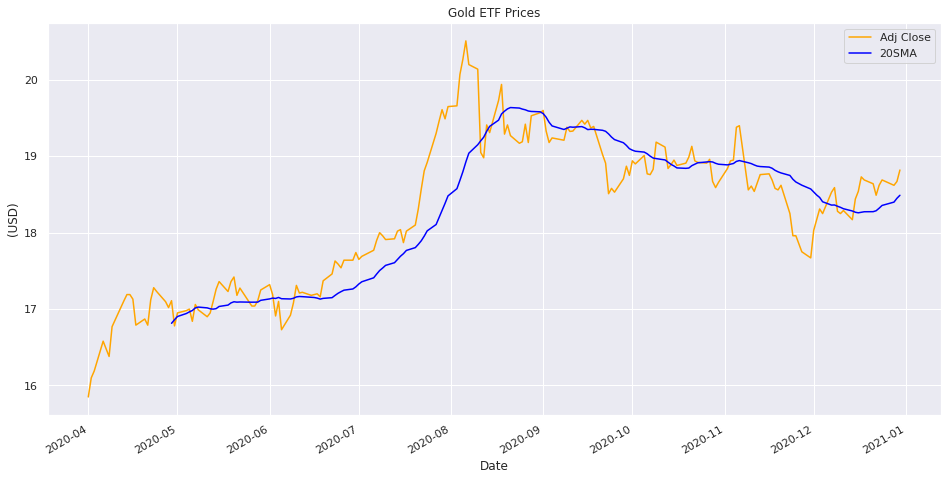

In [ ]:
# Gold Graph
fig = plt.figure(figsize=(16,8))
ax1 = gold_etf['Adj Close'].plot(color='orange')
ax2 = gold_etf['20SMA'].plot(color='blue')
ax1.legend()
plt.title('Gold ETF Prices')
plt.ylabel('(USD)')

Text(0.5, 1.0, 'Nikkei 1570 ETF Prices')

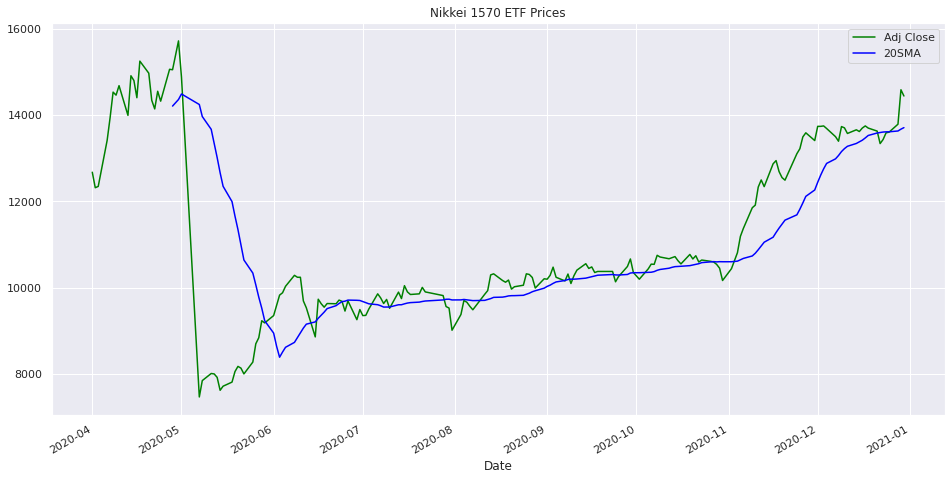

In [ ]:
# Nikkei Graph
fig = plt.figure(figsize=(16,8))
ax3 = nikkei_etf['Adj Close'].plot(color='green')
ax4 = nikkei_etf['20SMA'].plot(color='blue')
ax3.legend()
plt.title('Nikkei 1570 ETF Prices')

Text(0, 0.5, '(USD)')

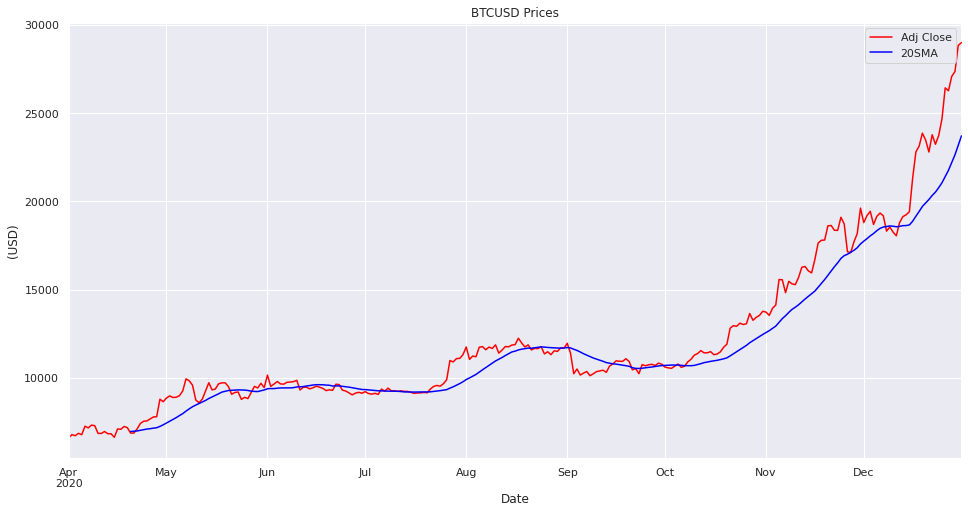

In [ ]:
# BTC Graph
fig = plt.figure(figsize=(16,8))
#ax5 = btcusd['close'].plot(color='red')
ax5 = btcusd['Adj Close'].plot(color='red')
ax6 = btcusd['20SMA'].plot(color='blue')
ax5.legend()
plt.title('BTCUSD Prices')
plt.ylabel('(USD)')

In [ ]:
#btcusd=btcusd.reset_index()
#btcusd[btcusd.columns[0]] = pd.to_datetime(btcusd[btcusd.columns[0]])
#btcusd=btcusd.set_index('formatted_date')

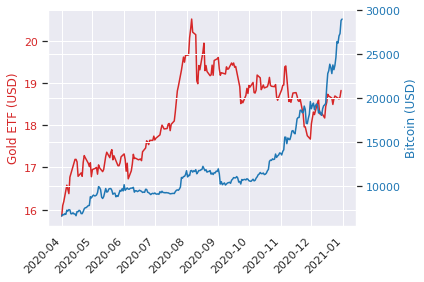

In [ ]:
# Gold and BTC Graph
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Gold ETF (USD)', color=color)
ax1.plot(gold_etf['Adj Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Bitcoin (USD)', color=color)  # we already handled the x-label with ax1
#ax2.plot(btcusd['close'], color=color)
ax2.plot(btcusd['Adj Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate(rotation=45)
plt.show()

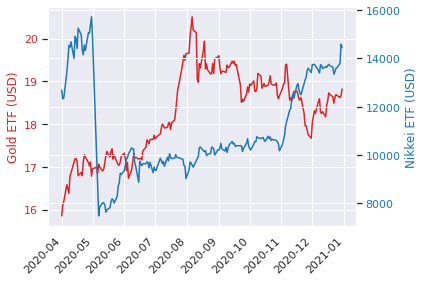

In [ ]:
# Gold and Nikkei ETF Graph
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Gold ETF (USD)', color=color)
ax1.plot(gold_etf['Adj Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Nikkei ETF (USD)', color=color)  # we already handled the x-label with ax1
ax2.plot(nikkei_etf['Adj Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate(rotation=45)
plt.show()

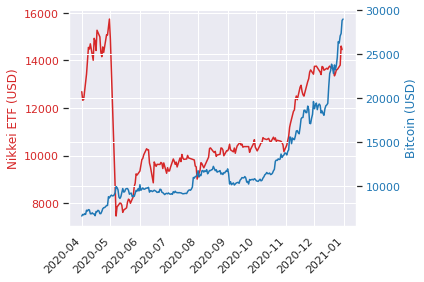

In [ ]:
# Nikkei and BTC Graph
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Nikkei ETF (USD)', color=color)
ax1.plot(nikkei_etf['Adj Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Bitcoin (USD)', color=color)  # we already handled the x-label with ax1
ax2.plot(btcusd['Adj Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate(rotation=45)
plt.show()

# 5. Fitting Garch Model

In [ ]:
gold_etf = gold_etf.reset_index()
gold_etf.dropna(inplace=True)

In [ ]:
gold_etf_q2 = gold_etf[gold_etf['Date'].dt.quarter==2]
gold_etf_q3 = gold_etf[gold_etf['Date'].dt.quarter==3]
gold_etf_q4 = gold_etf[gold_etf['Date'].dt.quarter==4]

In [ ]:
#GARCH
def garch(df, p, q):
  garch_df = arch_model(df.iloc[:,[0,2]].set_index('Date')*100, mean='Zero', vol='Garch', p=p, q=q)
  garch_df_fit = garch_df.fit()
  return garch_df_fit.summary()

In [ ]:
garch(gold_etf_q2, 1, 1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 56.0033257600036
Iteration:      2,   Func. Count:     11,   Neg. LLF: 55.9956081803841
Iteration:      3,   Func. Count:     18,   Neg. LLF: 55.990532149807926
Iteration:      4,   Func. Count:     24,   Neg. LLF: 55.98797019433553
Iteration:      5,   Func. Count:     29,   Neg. LLF: 55.98622584256829
Iteration:      6,   Func. Count:     34,   Neg. LLF: 55.98607465489053
Iteration:      7,   Func. Count:     39,   Neg. LLF: 55.98607183592322
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 55.98607183593302
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.023
Vol Model:                      GARCH   Log-Likelihood:               -55.9861
Distribution:                  Normal   AIC:                           117.972
Method:            Maximum Likelihood   BIC:                           123.325
                                        No. Observations:                   44
Date:                Tue, Jan 25 2022   Df Residuals:                       44
Time:                        07:04:29   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.3333      0.172      1.939  5.249e-02 [-3.580e-03,  0.670]
alpha[1]       0.1631      0.186      0.875      0.382    [ -0.202,  0.528]
beta[1]        0.3890      0.235      1.654  9.819e-02 [-7.204e-02,  0.850]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
garch(gold_etf_q3, 1, 1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 102.84238294940238
Iteration:      2,   Func. Count:     14,   Neg. LLF: 102.77409570629652
Iteration:      3,   Func. Count:     20,   Neg. LLF: 102.60068807827011
Iteration:      4,   Func. Count:     26,   Neg. LLF: 102.5713816197618
Iteration:      5,   Func. Count:     32,   Neg. LLF: 102.5640247834209
Iteration:      6,   Func. Count:     37,   Neg. LLF: 102.56161483786428
Iteration:      7,   Func. Count:     42,   Neg. LLF: 102.56132442792844
Iteration:      8,   Func. Count:     47,   Neg. LLF: 102.56127320442806
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 102.56127320471423
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -102.561
Distribution:                  Normal   AIC:                           211.123
Method:            Maximum Likelihood   BIC:                           217.599
                                        No. Observations:                   64
Date:                Tue, Jan 25 2022   Df Residuals:                       64
Time:                        07:04:29   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.1584      0.134      1.179      0.238 [ -0.105,  0.422]
alpha[1]       0.1957      0.248      0.788      0.431 [ -0.291,  0.682]
beta[1]        0.7409  6.754e-02     10.969  5.400e-28 [  0.608,  0.873]
========================================================================

Covariance estimator: robust
"""

In [ ]:
garch(gold_etf_q4, 1, 1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 90.70367132778173
Iteration:      2,   Func. Count:     12,   Neg. LLF: 90.7019413646433
Iteration:      3,   Func. Count:     17,   Neg. LLF: 90.59324239603669
Iteration:      4,   Func. Count:     22,   Neg. LLF: 90.58929261598448
Iteration:      5,   Func. Count:     27,   Neg. LLF: 90.55854093053524
Iteration:      6,   Func. Count:     33,   Neg. LLF: 90.55547888836415
Iteration:      7,   Func. Count:     39,   Neg. LLF: 90.5307513663968
Iteration:      8,   Func. Count:     45,   Neg. LLF: 90.5159124287005
Iteration:      9,   Func. Count:     51,   Neg. LLF: 90.50681636722503
Iteration:     10,   Func. Count:     57,   Neg. LLF: 90.4952976380945
Iteration:     11,   Func. Count:     63,   Neg. LLF: 90.49234126926018
Iteration:     12,   Func. Count:     68,   Neg. LLF: 90.4911032822086
Iteration:     13,   Func. Count:     73,   Neg. LLF: 90.49109197476365
Optimization terminated successfully.    (Exit mode 0)
            Cu

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -90.4911
Distribution:                  Normal   AIC:                           186.982
Method:            Maximum Likelihood   BIC:                           193.412
                                        No. Observations:                   63
Date:                Tue, Jan 25 2022   Df Residuals:                       63
Time:                        07:04:29   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0903  6.214e-02      1.453      0.146   [-3.153e-02,  0.212]
alpha[1]       0.0000  5.118e-03      0.000      1.000 [-1.003e-02,1.003e-02]
beta[1]        0.9173  5.855e-02     15.668  2.516e-55      [  0.803,  1.032]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
### EGARCH
def garch_e(df, p, q):
  garch_df = arch_model(df.iloc[:,[0,2]].set_index('Date')*100, mean='Zero', vol='EGARCH', p=p, q=q)
  garch_df_fit = garch_df.fit()
  return garch_df_fit.summary()

In [ ]:
garch_e(gold_etf,1,1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 252.32029376162407
Iteration:      2,   Func. Count:     13,   Neg. LLF: 252.20451657990532
Iteration:      3,   Func. Count:     20,   Neg. LLF: 252.15896075297604
Iteration:      4,   Func. Count:     27,   Neg. LLF: 252.15825968521904
Iteration:      5,   Func. Count:     32,   Neg. LLF: 252.15279765454525
Iteration:      6,   Func. Count:     37,   Neg. LLF: 252.15267282042535
Iteration:      7,   Func. Count:     42,   Neg. LLF: 252.15267148996367
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 252.15267148992157
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - EGARCH Model Results                       
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                     EGARCH   Log-Likelihood:               -252.153
Distribution:                  Normal   AIC:                           510.305
Method:            Maximum Likelihood   BIC:                           519.730
                                        No. Observations:                  171
Date:                Tue, Jan 25 2022   Df Residuals:                      171
Time:                        07:04:29   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0266  4.022e-02      0.661      0.509 [-5.225e-02,  0.105]
alpha[1]       0.2117      0.147      1.445      0.149 [-7.550e-02,  0.499]
beta[1]        0.8799  6.452e-02     13.639  2.358e-42    [  0.753,  1.006]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
### TGARCH
def garch_t(df, p, q):
  garch_df = arch_model(df.iloc[:,[0,2]].set_index('Date')*100, mean='Zero', vol='Garch', p=p, o=1, q=q, power=q)
  garch_df_fit = garch_df.fit()
  return garch_df_fit.summary()

In [ ]:
garch_t(gold_etf, 1, 1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 254.29239376945043
Iteration:      2,   Func. Count:     16,   Neg. LLF: 253.98267436235142
Iteration:      3,   Func. Count:     23,   Neg. LLF: 252.8179491883595
Iteration:      4,   Func. Count:     30,   Neg. LLF: 251.979786062786
Iteration:      5,   Func. Count:     37,   Neg. LLF: 251.26796902686715
Iteration:      6,   Func. Count:     46,   Neg. LLF: 251.26309459537146
Iteration:      7,   Func. Count:     53,   Neg. LLF: 250.97305129678432
Iteration:      8,   Func. Count:     59,   Neg. LLF: 250.76409701496883
Iteration:      9,   Func. Count:     65,   Neg. LLF: 250.62422714733614
Iteration:     10,   Func. Count:     71,   Neg. LLF: 250.49853012822933
Iteration:     11,   Func. Count:     77,   Neg. LLF: 249.92169975104161
Iteration:     12,   Func. Count:     84,   Neg. LLF: 249.82578051889968
Iteration:     13,   Func. Count:     90,   Neg. LLF: 249.76961354647477
Iteration:     14,   Func. Count:     96,   Neg. LLF: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Zero Mean - TARCH/ZARCH Model Results                     
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -249.706
Distribution:                  Normal   AIC:                           507.412
Method:            Maximum Likelihood   BIC:                           519.978
                                        No. Observations:                  171
Date:                Tue, Jan 25 2022   Df Residuals:                      171
Time:                        07:04:29   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0492  4.990e-02      0.985      0.325 [-4.864e-02,  0.147]
alpha[1]       0.0973      0.110      0.888      0.375    [ -0.117,  0.312]
gamma[1]      -0.0973  6.443e-02     -1.510      0.131  [ -0.224,2.897e-02]
beta[1]        0.9154  9.856e-02      9.288  1.566e-20    [  0.722,  1.109]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
### IGARCH
def garch_i(df, p, q):
  garch_df = arch_model(df.iloc[:,[0,2]].set_index('Date')*100, mean='Zero', vol='FIGARCH', p=p, q=q)
  garch_df_fit = garch_df.fit()
  return garch_df_fit.summary()

In [ ]:
garch_i(gold_etf,p=1,q=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 251.72945065119032
Iteration:      2,   Func. Count:     15,   Neg. LLF: 251.61156543583553
Iteration:      3,   Func. Count:     21,   Neg. LLF: 250.98553703485462
Iteration:      4,   Func. Count:     27,   Neg. LLF: 249.85844571798586
Iteration:      5,   Func. Count:     33,   Neg. LLF: 249.70632233868645
Iteration:      6,   Func. Count:     40,   Neg. LLF: 249.54709899096764
Iteration:      7,   Func. Count:     47,   Neg. LLF: 249.47243715304162
Iteration:      8,   Func. Count:     53,   Neg. LLF: 249.44839227525244
Iteration:      9,   Func. Count:     59,   Neg. LLF: 249.43173146733469
Iteration:     10,   Func. Count:     65,   Neg. LLF: 249.42374199616916
Iteration:     11,   Func. Count:     71,   Neg. LLF: 249.42367650537886
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 249.42367670601323
            Iterations: 11
            Function evaluations: 71
            Gradient ev

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Zero Mean - FIGARCH Model Results                       
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                    FIGARCH   Log-Likelihood:               -249.424
Distribution:                  Normal   AIC:                           506.847
Method:            Maximum Likelihood   BIC:                           519.414
                                        No. Observations:                  171
Date:                Tue, Jan 25 2022   Df Residuals:                      171
Time:                        07:04:29   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0922      0.882      0.105      0.917    [ -1.636,  1.821]
phi            0.0000      2.939      0.000      1.000    [ -5.760,  5.760]
d              0.3982      3.273      0.122      0.903    [ -6.017,  6.814]
beta           0.3982      0.206      1.934  5.311e-02 [-5.339e-03,  0.802]
===========================================================================

Covariance estimator: robust
"""

Long run variance

GARCH: 0.1549 / (1 - 0.1302 - 0.7472) = 1.26

GARCH-M:

TGARCH: 0.0492 / (1 - 0.9154) = 0.58

EGARCH: 0.0266 / (1 - 0.2117 - 0.8799) = -0.29

IGARCH: 0.0922 / (1 - 0.3982) = 0.15

# 6. Assessing stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
nikkei_etf = nikkei_etf.reset_index()
nikkei_etf.dropna(inplace=True)
btcusd = btcusd.reset_index()
btcusd.dropna(inplace=True)

In [ ]:
btcusd_q2 = btcusd[btcusd['Date'].dt.quarter==2]
btcusd_q3 = btcusd[btcusd['Date'].dt.quarter==3]
btcusd_q4 = btcusd[btcusd['Date'].dt.quarter==4]

In [ ]:
nikkei_etf_q2 = nikkei_etf[nikkei_etf['Date'].dt.quarter==2]
nikkei_etf_q3 = nikkei_etf[nikkei_etf['Date'].dt.quarter==3]
nikkei_etf_q4 = nikkei_etf[nikkei_etf['Date'].dt.quarter==4]

In [ ]:
### test for stationarity
def stn_test(df):
  X = df.ret.dropna().values
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
stn_test(gold_etf_q2)

ADF Statistic: -8.500637
p-value: 0.000000
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604


returns for gold etf Q2 is stationary since test statistic is smaller than all critical values


In [ ]:
stn_test(nikkei_etf_q2)

ADF Statistic: -6.357972
p-value: 0.000000
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606


returns for nikkei etf Q2 is stationary since test statistic is smaller than all critical values

In [ ]:
stn_test(btcusd_q2)

ADF Statistic: -5.404124
p-value: 0.000003
Critical Values:
	1%: -3.530
	5%: -2.905
	10%: -2.590


returns for btc Q2 is stationary since test statistic is smaller than all critical values

# 7. Modelling Cointegration

## 7.1

In [ ]:
import statsmodels.tsa.stattools as ts

In [ ]:
def coint(df, col1, col2):
  x = df[col1]
  y = df[col2]
  co_integrate = ts.coint(x,y)
  print('p-value: ',co_integrate[1])
  if co_integrate[1] < 0.05:
    print(df.columns[1] +': Null hypothesis is false. Co-Integration exists')
  else:
    print(df.columns[1] + ': Null hypothesis is true. Co-Integration does not exist')
  #if (co_integrate[1] > co_integrate[2][2]) == True:
  #  print(df.columns[1] + ': Co-Integration does not exists at 10%')
  #else:
  #  print(df.columns[1] +': Co-Integration exists at 10%')

In [ ]:
gold_etf_q2 = gold_etf_q2.set_index('Date')
nikkei_etf_q2 = nikkei_etf_q2.set_index('Date')
btcusd_q2 = btcusd_q2.set_index('Date')
gold_etf_q3 = gold_etf_q3.set_index('Date')
nikkei_etf_q3 = nikkei_etf_q3.set_index('Date')
btcusd_q3 = btcusd_q3.set_index('Date')

gold_etf_q3.rename(columns={'ret':'gold_ret'}, inplace=True)
btcusd_q3.rename(columns={'ret':'btc_ret'}, inplace=True)
nikkei_etf_q3.rename(columns={'ret':'n_ret'}, inplace=True)

gold_etf_q3.rename(columns={'Adj Close':'gold_AdjClose'}, inplace=True)
btcusd_q3.rename(columns={'Adj Close':'btc_AdjClose'}, inplace=True)
nikkei_etf_q3.rename(columns={'Adj Close':'n_AdjClose'}, inplace=True)

gold_etf_q3.rename(columns={'20SMA':'gold_20SMA'}, inplace=True)
btcusd_q3.rename(columns={'20SMA':'btc_20SMA'}, inplace=True)
nikkei_etf_q3.rename(columns={'20SMA':'n_20SMA'}, inplace=True)

In [ ]:
all_q3 = pd.concat([gold_etf_q3, btcusd_q3, nikkei_etf_q3], axis=1).reindex(gold_etf_q3.index)

In [ ]:
all_q3 = all_q3.dropna()

In [ ]:
gold_etf_q2.rename(columns={'ret':'gold_ret'}, inplace=True)
btcusd_q2.rename(columns={'ret':'btc_ret'}, inplace=True)
nikkei_etf_q2.rename(columns={'ret':'n_ret'}, inplace=True)

gold_etf_q2.rename(columns={'Adj Close':'gold_AdjClose'}, inplace=True)
btcusd_q2.rename(columns={'Adj Close':'btc_AdjClose'}, inplace=True)
nikkei_etf_q2.rename(columns={'Adj Close':'n_AdjClose'}, inplace=True)

gold_etf_q2.rename(columns={'20SMA':'gold_20SMA'}, inplace=True)
btcusd_q2.rename(columns={'20SMA':'btc_20SMA'}, inplace=True)
nikkei_etf_q2.rename(columns={'20SMA':'n_20SMA'}, inplace=True)

In [ ]:
all_q2 = pd.concat([gold_etf_q2, btcusd_q2, nikkei_etf_q2], axis=1).reindex(gold_etf_q2.index)

In [ ]:
all_q2 = all_q2.dropna()

### Engle-Graanger test for cointegration

In [ ]:
coint(all_q2, 'btc_ret', 'gold_ret')

p-value:  2.2572313329218947e-10
gold_ret: Null hypothesis is false. Co-Integration exists


In [ ]:
coint(all_q2, 'btc_ret', 'n_ret')

p-value:  1.4784208907524208e-09
gold_ret: Null hypothesis is false. Co-Integration exists


In [ ]:
coint(all_q2, 'n_ret', 'gold_ret')

p-value:  6.493359708579223e-08
gold_ret: Null hypothesis is false. Co-Integration exists


In [ ]:
coint(all_q3, 'btc_ret', 'gold_ret')

p-value:  1.960903737003615e-14
gold_ret: Null hypothesis is false. Co-Integration exists


In [ ]:
coint(all_q3, 'btc_ret', 'n_ret')

p-value:  8.183441127751874e-11
gold_ret: Null hypothesis is false. Co-Integration exists


In [ ]:
coint(all_q3, 'gold_ret', 'n_ret')

p-value:  0.1892134901876178
gold_ret: Null hypothesis is true. Co-Integration does not exist


[Johansen test for cointegration](https://)

The null hypothesis was that the time series are not cointegrated. When we reject the null hypothesis, we suggest that the series are cointegrated.

The trace statistics tells us if the sum of the eigenvalues is 0. If the null hypothesis i.e. r<=0 has a trace statistic greater than the trace critical values, the null hypothesis can be rejected at a that confidence level (90%, 95% or 99%). The eigen statistics stores the eigenvalues in decreasing order of magnitude. This gives us information about how strongly cointegrated the series are or how strong is the tendency to mean revert. If the eigen statistic for the null hypothesis is greater than the critical values, null hypothesis can be rejected at that confidence level.

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [ ]:
all_q3.head()

,gold_AdjClose,gold_ret,gold_20SMA,btc_AdjClose,btc_ret,btc_20SMA,n_AdjClose,n_ret,n_20SMA
Date,,,,,,,,,
2020-07-01,17.650000,-0.005073,17.3280,9228.325195,0.009885,9345.679199,9350.0,-0.014752,9676.75
2020-07-02,17.690001,0.002266,17.3575,9123.410156,-0.011369,9327.807520,9355.0,0.000535,9650.50
2020-07-06,17.770000,0.004522,17.4095,9375.474609,0.033231,9268.728369,9855.0,0.037368,9602.50
2020-07-07,17.900000,0.007316,17.4585,9252.277344,-0.013140,9257.329492,9760.0,-0.009640,9578.50
2020-07-08,18.000000,0.005587,17.5045,9428.333008,0.019028,9258.154102,9630.0,-0.013320,9548.00


In [ ]:
def johansen(df, det_order, k_ar_diff):
  jres = coint_johansen(df, det_order=det_order, k_ar_diff=k_ar_diff)
  print('Trace statistic for r <= 0: ', jres.trace_stat[0])
  print('Trace critical values for r <= 0: ',jres.trace_stat_crit_vals[0])
  print('Eigen statistic for r <= 0: ', jres.max_eig_stat[0])
  print('Eigen critical values for r <= 0: ',jres.max_eig_stat_crit_vals[0])

In [ ]:
# 'btc_ret', 'gold_ret' Q2
johansen(all_q2.iloc[:, [0,3]].values, det_order=0, k_ar_diff=1)

Trace statistic for r <= 0:  22.673272759276283
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  22.597655609148358
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]


The trace statistic and eigen statistic is greater than the critical values. Hence, we can reject the null hypothesis with 99% confidence.

Gold and bitcoin Q2: Co-Integration exists



In [ ]:
# 'btc_ret', 'n_ret' Q2
johansen(all_q2.iloc[:, [3,6]].values, det_order=-1, k_ar_diff=1)

Trace statistic for r <= 0:  46.756135367865824
Trace critical values for r <= 0:  [10.4741 12.3212 16.364 ]
Eigen statistic for r <= 0:  46.53433712779621
Eigen critical values for r <= 0:  [ 9.4748 11.2246 15.0923]


The trace statistic and eigen statistic is greater than the critical values. Hence, we can reject the null hypothesis.

Equity and bitcoin Q2: Co-Integration exists


In [ ]:
#'n_ret', 'gold_ret' Q2
johansen(all_q2.iloc[:, [6,0]].values, det_order=0, k_ar_diff=1)

Trace statistic for r <= 0:  37.15397434317917
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  36.21288731707078
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]


The trace statistic and eigen statistic is greater than the critical values. Hence, we can reject the null hypothesis.

Gold and Equity Q2: Co-Integration exists

In [ ]:
# 'btc_ret', 'gold_ret' Q3
johansen(all_q3.iloc[:, [0,3]].values, det_order=0, k_ar_diff=1)

Trace statistic for r <= 0:  12.088054762383367
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  8.097121838698252
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]


The trace statistic and eigen statistic is less than the critical values. Hence, we can't reject the null hypothesis.

Gold and bitcoin Q3 : Co-Integration does not exist

In [ ]:
# 'btc_ret', 'n_ret' Q3
johansen(all_q3.iloc[:, [3,6]].values, det_order=-1, k_ar_diff=1)

Trace statistic for r <= 0:  3.7566589497571523
Trace critical values for r <= 0:  [10.4741 12.3212 16.364 ]
Eigen statistic for r <= 0:  2.8657837797408496
Eigen critical values for r <= 0:  [ 9.4748 11.2246 15.0923]


The trace statistic and eigen statistic is less than the critical values. Hence, we can't reject the null hypothesis.

bitcoin and Equity Q3 : Co-Integration does not exist

In [ ]:
#'n_ret', 'gold_ret' Q3
johansen(all_q3.iloc[:, [6,0]].values, det_order=0, k_ar_diff=1)

Trace statistic for r <= 0:  10.606541691142455
Trace critical values for r <= 0:  [13.4294 15.4943 19.9349]
Eigen statistic for r <= 0:  7.722138963352518
Eigen critical values for r <= 0:  [12.2971 14.2639 18.52  ]


The trace statistic and eigen statistic is less than the critical values. Hence, we can't reject the null hypothesis.

gold and Equity Q3 : Co-Integration does not exist

## 7.2

Based on the Engle-Garner and the Johanson tests, we see that while both the tests agree mostly, they do differ in a few cases.

Both the tests agree on Quarter 2 and between gold and equity in Quarter 3.

They differ in quarter 3 between bitcoin and gold, and equity and bitcoin. While Engle-Garner tests says that these assests are cointegrated, Johanson test suggests no cointegration.

## 7.3, 7.4 and 7.5
Modeling and forecasting using VAR


In [ ]:
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.api import VAR

In [ ]:
# check stationaroty of Q4
stn_test(gold_etf_q4)

ADF Statistic: -7.468188
p-value: 0.000000
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592


Gold ETF is stationary since test statistic in Q4


In [ ]:
stn_test(nikkei_etf_q4)

ADF Statistic: -7.313000
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593



Euity ETF is stationary since test statistic in Q4


In [ ]:
stn_test(btcusd_q4)

ADF Statistic: -9.222197
p-value: 0.000000
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


Bitcoin ETF is stationary since test statistic in Q4


In [ ]:
df_q4 = pd.concat([gold_etf_q2, btcusd_q2, nikkei_etf_q2], axis=1).reindex(gold_etf_q2.index)
df_q4 = df_q4[['gold_AdjClose','btc_AdjClose','n_AdjClose']]

In [ ]:
#split into traning and test
n_test = 5
X_train, X_test = df_q4[0:-n_test], df_q4[-n_test:]
print(X_train.shape)
print(X_test.shape)

(39, 3)
(5, 3)


In [ ]:
#series transformation
X_train_log = np.log(X_train)
X_train_log_diff = X_train_log.diff().dropna()

X_test_log = np.log(X_test)
X_test_log_diff = X_test_log.diff().dropna()

X_train_log_diff.describe()

,gold_AdjClose,btc_AdjClose,n_AdjClose
count,33.000000,33.000000,33.000000
mean,0.001301,-0.000283,0.006325
std,0.008964,0.039945,0.034293
min,-0.021875,-0.134756,-0.073462
25%,-0.004112,-0.013243,-0.008346
50%,0.003450,0.002475,0.008792
75%,0.008811,0.023289,0.020828
max,0.013376,0.074310,0.094232


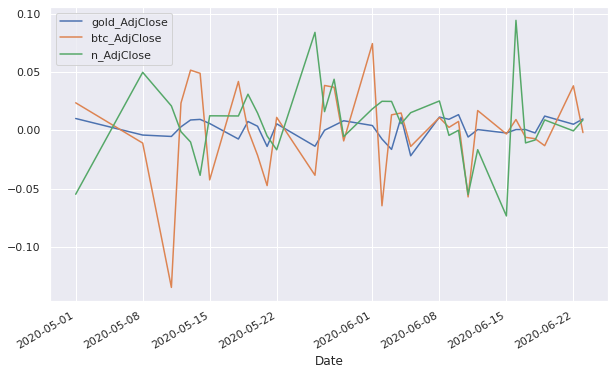

In [ ]:
X_train_log_diff.plot(figsize=(10,6))
plt.show()

In [ ]:
#Initiate VAR model
model_var = VAR(endog=X_train_log_diff)
res_var = model_var.select_order(7)
res_var.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-23.03,-22.88,9.997e-11,-22.98
1,-22.97,-22.39,1.063e-10,-22.80
2,-22.59,-21.58,1.605e-10,-22.30
3,-22.30,-20.85,2.347e-10,-21.88
4,-21.99,-20.10,3.780e-10,-21.45
5,-21.95,-19.62,5.428e-10,-21.28
6,-23.23,-20.47,2.694e-10,-22.44
7,-28.60*,-25.41*,4.094e-12*,-27.68*


In [ ]:
#Fit to a VAR model
model_fit_var = model_var.fit(maxlags=7)
#Print a summary of the model results
model_fit_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jan, 2022
Time:                     08:42:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -25.4057
Nobs:                     26.0000    HQIC:                  -27.6796
Log likelihood:           327.114    FPE:                4.09404e-12
AIC:                     -28.5993    Det(Omega_mle):     6.50652e-13
--------------------------------------------------------------------
Results for equation gold_AdjClose
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.005080         0.005092            0.998           0.318
L1.gold_AdjClose        -0.332411         0.549706           -0.605           0.545
L1.btc_AdjClose         -0.090001       

In [ ]:
# Forecast VAR model
# Get the lag order
lag_order_var = model_fit_var.k_ar
#print(lag_order_var)
# Input data for forecasting
input_data = X_train_log_diff.values[-lag_order_var:]
# forecasting
pred_var = model_fit_var.forecast(y=input_data, steps=len(X_test_log_diff))
pred_var = (pd.DataFrame(pred_var, index=X_test_log_diff.index, columns=X_test_log_diff.columns + '_pred'))
print(X_test_log_diff)
print(pred_var)

            gold_AdjClose  btc_AdjClose  n_AdjClose
Date                                               
2020-06-25      -0.002847     -0.005253   -0.023518
2020-06-26       0.005685     -0.011059    0.024551
2020-06-29       0.000000      0.003044   -0.045930
2020-06-30       0.005653     -0.005768    0.025075
            gold_AdjClose_pred  btc_AdjClose_pred  n_AdjClose_pred
Date                                                              
2020-06-25           -0.039978          -0.119437         0.022543
2020-06-26            0.029043           0.158399        -0.032598
2020-06-29           -0.007899          -0.054332         0.039534
2020-06-30           -0.006051           0.009126         0.099049


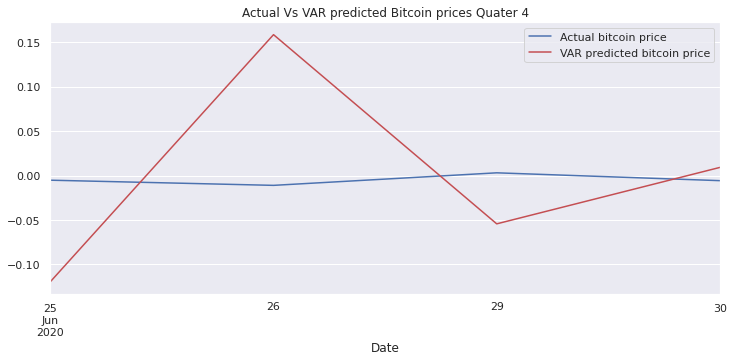

In [ ]:
#fig, ax1 = plt.subplots(figsize=(12,5))
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1 = X_test_log_diff['btc_AdjClose'].plot(color='b', label='Actual bitcoin price')
#ax2 = ax1.twinx()
ax2 = pred_var['btc_AdjClose_pred'].plot(color='r', label='VAR predicted bitcoin price')
ax1.legend(loc=1)
ax2.legend(loc=1)

plt.title('Actual Vs VAR predicted Bitcoin prices Quater 4')
plt.show()

In [ ]:
#Calculate mean squared error
error_var = np.sum([(X_test_log_diff['btc_AdjClose'][i]- pred_var['btc_AdjClose_pred'][i])**2 for i in range(len(X_test_log_diff['btc_AdjClose']))])
print('MSE: %f' % error_var)

MSE: 0.045268


Modeling and forecasting using VECM


In [ ]:
vecm = VECM(endog = X_train, k_ar_diff = 1, coint_rank = 1, deterministic = 'ci')
vecm_fit = vecm.fit()
vecm_fit.predict(steps=len(X_test))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: ignored

# 8. Correlation vs Cointegration

## 8.1

Correlation between two variables X and Y are symmetric. This means that correlation between X and Y is saame as Y and X.

\begin{equation}
Corr(X,Y) = Cov(X,Y) / [ Var(X) Var(Y)]
= \frac{\sum (X_{i} - \bar{X}) (Y_{i} - \bar{Y})}{\sqrt{\sum (X_{i} - \bar{X})^{2} \sum (Y_{i} - \bar{Y})^{2}}}
\end{equation}

Here Cov(X,Y) is the covariance of X and Y, Var(X) and Var(Y) are the variances of X and Y respectively.
Correlation ranges from -1 aand +1 where -1 pimples a negative relationship between X aand Y and +1 is positive. Correlation is symmetric in X and Y.



## 8.2

The coefficients of linear regression is not the same when X is regressed on Y and when Y is regressed on X except when X and Y aare standerdized as in the case of the correlation shown above.
When we fit a linear regression between two variables X and where Y is regressed on X, we are minimizing the mean squared error (loss function) to estimate the coefficients.

Y = beta0 + beta1 * X

to find beta0 and beta1, minimize the vertical distance on the Y vs X plot

Sum [ yi - (beta0 + beta1 * xi) ]

However, when we regress X on Y i.e.

X = alpha0 + alpha1 * Y
where  alpha0 = (- beta0/beta1)
            alpha1 = (1/beta1)

we are minimizing a different loss function, horizontal distance on the Y vs X plot

Sum [ xi - (alpha0 + alpha1 * yi) ]

Minimizing vertical distance results in a flatter slope while minimizing horizontal distance gives a steeper slope. But, if X and Y are standerdized i.e. centered on origin, the slope will be the same in both the cases.



## 8.3

A vector of I(1) variables Yt is said to be cointegrated if there exists beta such that Beta * Yt is stationary [1]

If there are r such linearly independent vectors beta_i , then Yt is cointegrated with rank r.
The matrix Beta = {beta_1, beta_2…beta_r} is called the cointegration matrix.

This cointegration vector Beta is same when x regresses on y and y regresses on X

